In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
# import libraries
# import cv2
import sys
import os
import time
import gc
import numpy as np
import numpy.matlib
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn as sk
import sklearn.decomposition
import skimage.draw
# import tensortools as tt
# import pywt
# import scaleogram as scg
import scipy
import scipy.signal
import pandas as pd

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

import multiprocessing
from multiprocessing import Pool

import imageio

import pywavesurfer.ws

# import torch
# import torch.cuda

# import mtaper_specgram
# import test_function

In [3]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

In [4]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/face-rhythm/functions')

# import mtaper_specgram

In [5]:
# # sys.path.insert(0, 'G:\My Drive\Research\Sabatini Lab Stuff - working\Code\PYTHON functions')
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON functions')
# import getVideoDirectoryProperties

In [3]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

torch_env


In [4]:
%matplotlib notebook

In [5]:
# ### find version of openCV
# # script currently works with v4.4.0
# (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
# print(f'OpenCV version: {major_ver}.{minor_ver}.{subminor_ver}')
# # print(cv2.getBuildInformation())

# ### find version of pytorch
# print(f'Pytorch version: {torch.__version__}')

## prep stuff
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

Autodetected operating system: Linux. Using "/" for directory slashes


In [6]:
## == IMPORT DATA ==

## import S2p data

dir_s2p = r'D:\RH_local\data\scanimage data\round 4 experiments\mouse 11.5\20210121\suite2p\plane0'

F = np.load(f'{dir_s2p}{slash_type}F.npy')
Fneu = np.load(f'{dir_s2p}{slash_type}Fneu.npy')
iscell = np.load(f'{dir_s2p}{slash_type}iscell.npy')
ops = np.load(f'{dir_s2p}{slash_type}ops.npy', allow_pickle=True)
spks = np.load(f'{dir_s2p}{slash_type}spks.npy')
stat = np.load(f'{dir_s2p}{slash_type}stat.npy', allow_pickle=True)

num_frames_S2p = F.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\RH_local\\data\\scanimage data\\round 4 experiments\\mouse 11.5\\20210121\\suite2p\\plane0/F.npy'

In [10]:
## == IMPORT LOGGER DATA ==
import scipy.io

dir_logger = r'D:\RH_local\data\scanimage data\round 4 experiments\mouse 11.5\20210121'
fileName_logger = 'logger.mat'
path_logger = f'{dir_logger}{slash_type}{fileName_logger}'
logger = scipy.io.loadmat(path_logger)['logger']

decoder_output = logger['decoder'][0][0][:,0]
cursor_output = logger['decoder'][0][0][:,2]


<IPython.core.display.Javascript object>


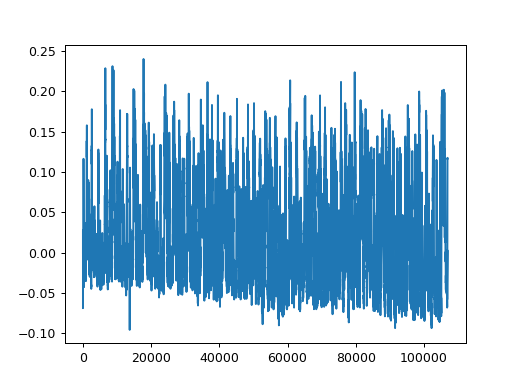

In [11]:
plt.figure()
plt.plot(decoder_output)
# plt.plot(cursor_output)

In [12]:
# ## == IMPORT DATA ==

# ## Import ROI Classifier data

# dir_ROIClassifier = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/'

# IsCell_ROIClassifier = np.load(f'{dir_ROIClassifier}{slash_type}IsCell_ROIClassifier.npy')
# ROI_Classifier_manual_selection_vars = np.load(f'{dir_ROIClassifier}{slash_type}manual_selection_vars.npy', allow_pickle=True)


<IPython.core.display.Javascript object>


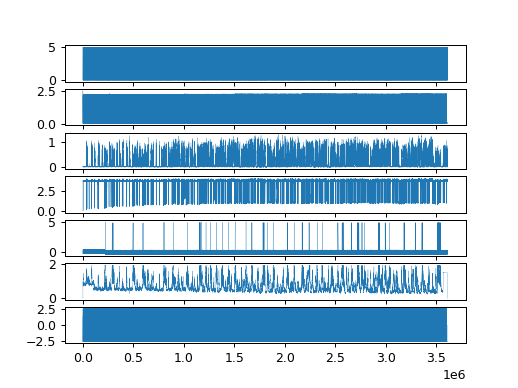

In [13]:
### import wavesurfer data

dir_ws = r'D:\RH_local\data\wavesurfer data\mouse 11.5\20210121'
fileName_ws = 'exp_0001.h5'

data_as_dict = pywavesurfer.ws.loadDataFile(filename=f'{dir_ws}{slash_type}{fileName_ws}', format_string='double' )
ws_data = data_as_dict[f'{list(data_as_dict.keys())[1]}']['analogScans']

fig = plt.figure()
for ii in range(ws_data.shape[0]):
    subplot_size = int(str(ws_data.shape[0]) + str(1) + str(ii+1))
    ax1 = fig.add_subplot(subplot_size)
    plt.plot(ws_data[ii,:] , linewidth=0.2)

<IPython.core.display.Javascript object>


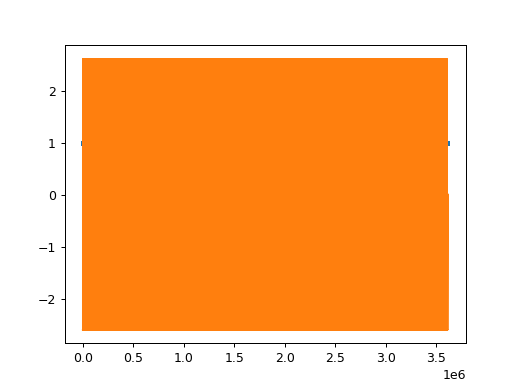

frames in scanimage movie = 108000
frames from ws galvo extraction movie = 108000
number of wavesurfer samples per imaging frame:  33.35883333333334
total elapsed time: 0.12 seconds


In [14]:
## == ALIGN DATA ==

# Get ws frame times in ws time. Everything should be aligned to ws frame times (S2pInd)

# Outputs:
# - ws_YGalvoFlybacks_bool_wsTime
# - ws_frameTimes_wsTime   ***

tic = time.time()
ws_YGalvoFlybacks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[6,:]) < -1)) > 0.5

ws_frameTimes_wsTime = np.array(np.where(ws_YGalvoFlybacks_bool_wsTime))[0,:]
ws_frameTimes_wsTime = ws_frameTimes_wsTime[0:num_frames_S2p+1]
# ws_frameTimes_wsTime = ws_frameTimes_wsTime[0:num_frames_S2p+1][:-1]

plt.figure()
plt.plot(ws_frameTimes_wsTime,np.ones(len(ws_frameTimes_wsTime)),'.')
plt.plot(ws_data[6,:])
print(f'frames in scanimage movie = {num_frames_S2p}')
print(f'frames from ws galvo extraction movie = {ws_frameTimes_wsTime.shape[0]}')

ws_samples_per_S2p_frame_rough = (ws_frameTimes_wsTime[-1] - ws_frameTimes_wsTime[0]) / num_frames_S2p
print(f'number of wavesurfer samples per imaging frame:  {ws_samples_per_S2p_frame_rough}')
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


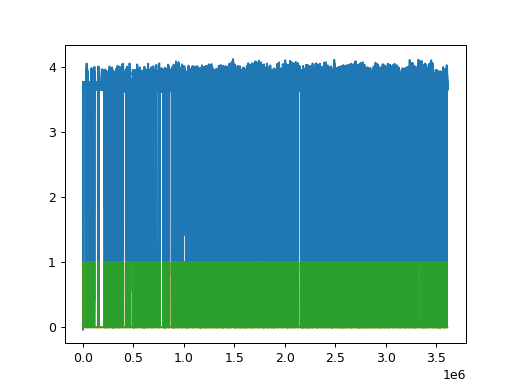

total elapsed time: 5.51 seconds


In [15]:
## Get lick times in S2p ind

# Outputs:
# - ws_licks_bool_wsTime
# - ws_licks_bool_S2pInd
# - ws_lickTimes_S2pInd   ***

tic = time.time()
ws_licks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[3,:]) < -0.2)) > 0.5

ws_licks_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_licks_bool_S2pInd[frame_num] = sum(ws_licks_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_lickTimes_S2pInd = np.array(np.where(ws_licks_bool_S2pInd))

plt.figure()
plt.plot(ws_data[3,:])
plt.plot(ws_licks_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_licks_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


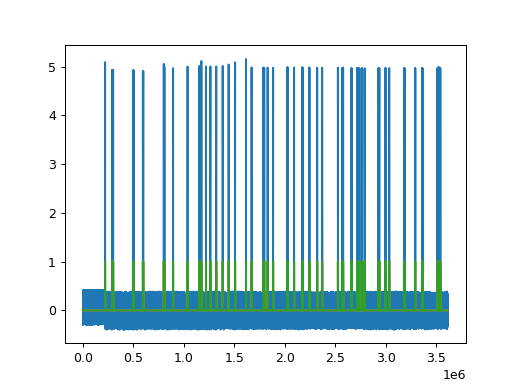

total elapsed time: 5.52 seconds


In [18]:
## Get reward delivery times in S2p ind

# Outputs:
# - ws_rewards_bool_wsTime
# - ws_rewards_bool_S2pInd
# - ws_rewardTimes_S2pInd   ***

tic = time.time()
ws_rewards_bool_wsTime = np.diff(np.int8(np.diff(ws_data[4,:]) > 1)) > 0.5


ws_rewards_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_rewards_bool_S2pInd[frame_num] = sum(ws_rewards_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_rewardTimes_S2pInd = np.array(np.where(ws_rewards_bool_S2pInd))

plt.figure()
plt.plot(ws_data[4,:])
plt.plot(ws_rewards_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_rewards_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [17]:
# np.double(ws_data[0,:].shape)/1000
# ws_data[0,int(987.5*1000):int(989*1000)]=0

<IPython.core.display.Javascript object>


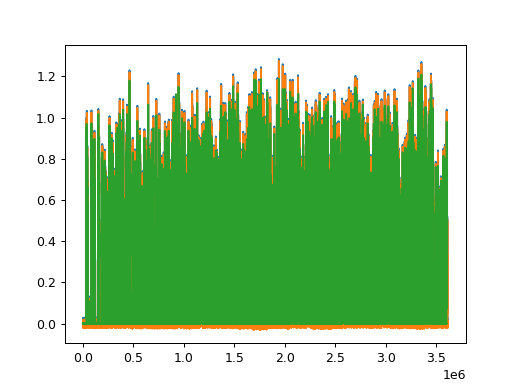

total elapsed time: 0.79 seconds


In [19]:
## Convert treadmill signal to S2p ind

# Outputs:
# - ws_treadmill_wsTime
# - ws_treadmill_S2pInd   ***

tic = time.time()
ws_treadmill_wsTime = ws_data[2,:] - np.percentile(ws_data[2,:], 20)

ws_treadmill_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_treadmill_S2pInd[frame_num] = sum(ws_treadmill_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]])
ws_treadmill_S2pInd = ws_treadmill_S2pInd / ws_samples_per_S2p_frame_rough

plt.figure()
plt.plot(ws_data[2,:])
plt.plot(ws_treadmill_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_treadmill_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


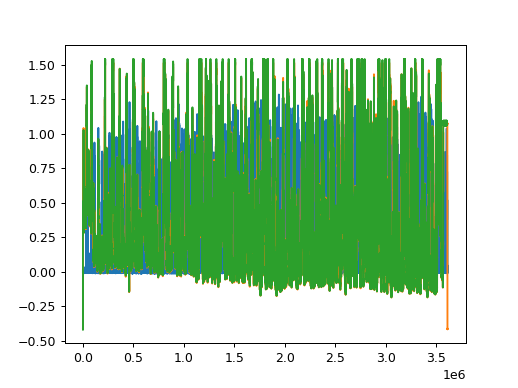

total elapsed time: 0.77 seconds


In [20]:
## Convert cursor voltage signal to S2p ind

# Outputs:
# - ws_treadmill_wsTime
# - ws_treadmill_S2pInd   ***

tic = time.time()
ws_cursorVoltage_wsTime = ws_data[5,:] - np.percentile(ws_data[5,:], 20)

ws_cursorVoltage_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_cursorVoltage_S2pInd[frame_num] = sum(ws_cursorVoltage_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]])
ws_cursorVoltage_S2pInd = ws_cursorVoltage_S2pInd / ws_samples_per_S2p_frame_rough

plt.figure()
plt.plot(ws_data[2,:])
plt.plot(ws_cursorVoltage_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_cursorVoltage_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [479]:
### Align logger with S2p

def align_dtw(alignment_index1, alignment_index2 , queryTrace):
#     ```
#     alignmentObj: alignment object from dtw-python call
#     queryTrace: the query (warped) variable from the dtw-python call
#     ```
    import numpy as np
    idx_multi_bool = np.diff(alignment_index2)==0
    idx_multi_bool = np.hstack([idx_multi_bool , 0]) + np.hstack([0 , idx_multi_bool])
    idx_multi = alignment_index2[np.where(idx_multi_bool)[0]]

    output = np.zeros(len(alignment_index2)) * np.nan
    for ii in range(len(alignment_index2)):
        if idx_multi_bool[ii]:
            tmp_idx_multi = alignment_index2==alignment_index2[ii]
            output[alignment_index2[ii]] = np.mean(queryTrace[alignment_index1[tmp_idx_multi]])
        else:
            output[alignment_index2[ii]] = queryTrace[alignment_index1[ii]]
    output = output[np.isnan(output)==0]
    return output

In [393]:
import dtw
from tqdm import trange
import numpy as np

## traces need to be pretty similar to use this code

## this dtw library is poorly documented and kind of janky. It won't let me put in large sequences. Anything over
# 40k samples takes up 100s of GB of memory. f that. so I wrote a thing to split it up into chunks. There are some
# edge effects, so the chunking also has some overlaps that are removed.

## The main outputs here are the matched indices: alignment_index1 and alignment_index2. Use these with the align_dtw
# function to warp a signal

input_template = ws_cursorVoltage_S2pInd
input_query = cursor_output/10000 -0.45

last_good_idx_query = int(np.max(np.where(np.isnan(input_query)==0)[0]))

template = input_template[:last_good_idx_query]
query = input_query[:last_good_idx_query]

chunk_size = 10000
overlap_size = 1000 # make even and the length of the window of possible shifts

num_chunks = int(np.ceil(len(template)/chunk_size))

alignment_list_extended = list(np.ones(num_chunks))
alignment_list_index1 = list(np.ones(num_chunks))
alignment_list_index2 = list(np.ones(num_chunks))
for ii in trange(num_chunks):
    idx_chunk_extended = np.arange(np.maximum(ii*chunk_size - overlap_size , 0), 
                                   np.minimum( (ii+1)*chunk_size + overlap_size , len(template)))
    template_chunk = template[idx_chunk_extended]
    query_chunk = query[idx_chunk_extended]
    alignment_list_extended[ii] = dtw.dtw(query_chunk , template_chunk, 
                    keep_internals=True,
                   step_pattern=dtw.rabinerJuangStepPattern(6,"c"),
#                     window_type="sakoechiba", window_args={'window_size':10000}
                   )
    
    if ii==0:
        idx_chunk = np.arange(0, np.min(np.where(alignment_list_extended[ii].index2==chunk_size)[0]))
    elif ii==num_chunks-1:
        idx_chunk = np.arange( np.min(np.where(alignment_list_extended[ii].index2==overlap_size)[0]),
                      len(alignment_list_extended[ii].index2))
    else:
        idx_chunk = np.arange( np.min(np.where(alignment_list_extended[ii].index2==overlap_size)[0]),
                              np.min(np.where(alignment_list_extended[ii].index2==chunk_size+overlap_size)[0]))
    alignment_list_index1[ii] = alignment_list_extended[ii].index1[idx_chunk]
    alignment_list_index2[ii] = alignment_list_extended[ii].index2[idx_chunk]

alignment_index1 = []
alignment_index2 = []
for ii in range(num_chunks):
    if ii==0:
        alignment_index1 = np.uint64(np.hstack(( alignment_index1 ,
                                            (alignment_list_index1[ii] + ii*chunk_size)) ))
        alignment_index2 = np.uint64(np.hstack(( alignment_index2 ,
                                            (alignment_list_index2[ii] + ii*chunk_size)) ))
    else:
        alignment_index1 = np.uint64(np.hstack(( alignment_index1 ,
                                                (alignment_list_index1[ii] + ii*chunk_size - overlap_size)) ))
        alignment_index2 = np.uint64(np.hstack(( alignment_index2 ,
                                                (alignment_list_index2[ii] + ii*chunk_size - overlap_size)) ))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:40<00:00,  3.65s/it]


<IPython.core.display.Javascript object>


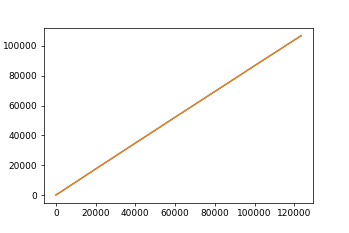

<IPython.core.display.Javascript object>


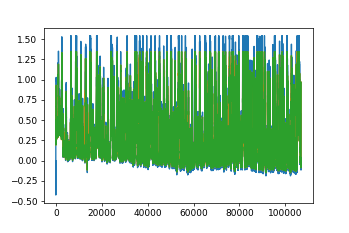

<IPython.core.display.Javascript object>


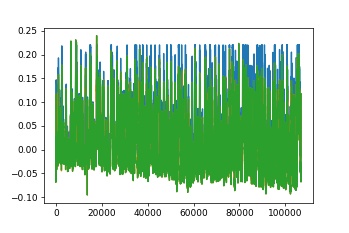

In [480]:
output = align_dtw(alignment_index1, alignment_index2 , query)

plt.figure()
plt.plot(alignment_index1)
plt.plot(alignment_index2)

plt.figure()
plt.plot(template)
plt.plot(query)
plt.plot(output)

decoder_output_S2pWarped = align_dtw(alignment_index1, alignment_index2 , decoder_output)

plt.figure()
plt.plot(template/7)
plt.plot(decoder_output)
plt.plot(decoder_output_S2pWarped)

In [719]:
### Make dFoF and zscored stuff
tic = time.time()
# F_neuSub = F - 0.7*Fneu
# F_baseline_static = np.percentile(F_neuSub,30)
# dF = F_neuSub - F_baseline_static
# dFoF = dF / F_baseline_static

F_baseline_static = np.percentile(F,30)
dF = F - F_baseline_static
dFoF = dF / F_baseline_static

F_zscore = scipy.stats.zscore(F, axis=1)
# spks_zscore = scipy.stats.zscore(spks, axis=1)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

total elapsed time: 6.44 seconds


In [397]:
## Make rolling baseline subtraction
sys.path.insert(0, 'G:\My Drive\Research\Sabatini Lab Stuff - working\Code\PYTHON functions')

import welford_moving_2D
import tqdm
from tqdm import trange

# list_of_values = [3, 5, 8, 10, 4, 8, 12, 15, 11, 9]
F_mean_rolling = np.ones_like(F.T) * np.nan
F_var_rolling = np.ones_like(F.T) * np.nan
win_size_rollingBaseline = round(60 * 30 * 10)
list_of_values = F.T
varSum_old = None
mean_old = None
for idx in trange(len(list_of_values)):

    mean_new = welford_moving_2D.update_mean(idx, list_of_values, win_size_rollingBaseline, mean_old)
    varSum_new = welford_moving_2D.update_varSum(idx, list_of_values, win_size_rollingBaseline, varSum_old)
    var_new = welford_moving_2D.varSum_to_var(idx, list_of_values, win_size_rollingBaseline, mean_new, varSum_new)

    F_mean_rolling[idx,:] = mean_new
    F_var_rolling[idx,:] = var_new
#     msg = "SMA=%.4f, PSA=%.4f, Var=%.4f" % (mean_new, varSum_new, var_new)
#     print("bar %i: %s" % (idx, msg))

    mean_old = mean_new
    varSum_old = varSum_new

eps = 1e-7
F_var_rolling[F_var_rolling<eps] = eps
F_zscore_roll = (list_of_values - F_mean_rolling)/np.sqrt(F_var_rolling)

100%|████████████████████████████████████████████████████████████████████████| 108000/108000 [01:14<00:00, 1443.09it/s]


In [418]:
## check to see if any of the traces are bad
# check if any traces are all NaNs
all_nan_traces = np.where( np.sum(np.isnan(F_zscore_roll) , axis=0) == F_zscore_roll.shape[0] )[0]
print(f'the following ROI #s are all NaNs: {all_nan_traces}')
any_nan_traces = np.where( np.sum(np.isnan(F_zscore_roll) , axis=0) > 0 )[0]
print(f'the following ROI #s have at least one NaN: {any_nan_traces}')
any_inf_traces = np.where( np.sum(F_zscore_roll==np.inf , axis=0) > 0 )[0]
print(f'the following ROI #s have at least one inf: {any_inf_traces}')
any_negInf_traces = np.where( np.sum(F_zscore_roll==-np.inf , axis=0) > 0 )[0]
print(f'the following ROI #s have at least one inf: {any_negInf_traces}')
all_0_traces = np.where( np.sum(F_zscore_roll==0 , axis=0) == F_zscore_roll.shape[0] )[0]
print(f'the following ROI #s are all 0s: {all_0_traces}')

the following ROI #s are all NaNs: []
the following ROI #s have at least one NaN: []
the following ROI #s have at least one inf: []
the following ROI #s have at least one inf: []
the following ROI #s are all 0s: []


<IPython.core.display.Javascript object>


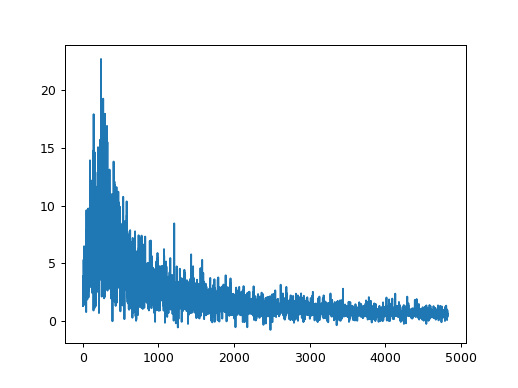

In [398]:
### Subselect good ROIs
n_roi = len(stat)
skew_all = np.zeros(n_roi) * np.nan
for ii in range(n_roi):
    skew_all[ii] = stat[ii]['skew']

plt.figure()
plt.plot(skew_all)

All stat keys: ['ypix' 'xpix' 'lam' 'footprint' 'mrs' 'mrs0' 'compact' 'med' 'npix'
 'overlap' 'radius' 'aspect_ratio' 'npix_norm' 'skew' 'std']

Using stat keys: ['mrs' 'mrs0' 'compact' 'npix' 'radius' 'skew' 'std']
Number of cells in yellow cluster: 1062


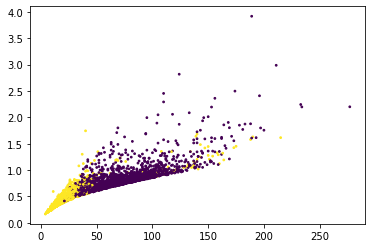

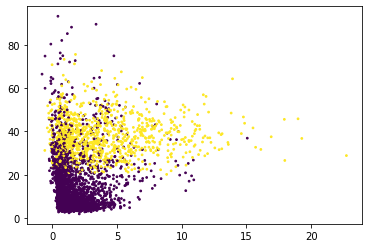

In [689]:
from sklearn import cluster
## Define ROIs as cells or not
# I am finding that the intersection of a k-means on some stat params and the built in classifier probability is pretty good
num_cells = len(stat)
all_stat_keys = stat[1].keys()
all_stat_keys = np.array([*all_stat_keys])

# stat_keys_toUse = [3,4,5,6,8,9,10,11,13,14]
# stat_keys_toUse = [6,8,10,13,14]
stat_keys_toUse = [4,5,6,8,10,13,14]
# stat_keys_toUse = np.array([6,8,9,10,11,13])

num_clusters_toUse = 2

data_for_classifier = np.zeros((num_cells , len(stat_keys_toUse)+1))

data_for_classifier_dict = {}
for ii,val in enumerate(all_stat_keys[stat_keys_toUse]):
#     print(val)
#     print(ii)
    data_for_classifier[:,ii] = [stat[ii][val] for ii in range(len(stat))]
    data_for_classifier_dict[val] = copy.deepcopy(data_for_classifier[:,ii])

data_for_classifier[:,ii+1] = [np.sum(stat[ii]['lam']/np.max(stat[ii]['lam'])) for ii in range(len(stat))]
data_for_classifier_dict['uniformity'] = [np.sum(stat[ii]['lam']/np.max(stat[ii]['lam'])) for ii in range(len(stat))]
# data_for_classifier = np.hstack((data_for_classifier, iscell[:,1].reshape((iscell.shape[0],1))))

cluster_IDs = sk.cluster.KMeans(n_clusters=num_clusters_toUse).fit(data_for_classifier).labels_
# cluster_IDs = sk.cluster.KMeans(n_clusters=3, random_state=2637).fit(data_for_classifier).labels_

%matplotlib inline
h = plt.figure()
# plt.scatter(data_for_classifier[:,7], data_for_classifier[:,9], s=2, c=cluster_IDs)
# plt.scatter([stat[ii]['aspect_ratio'] for ii in range(num_cells)], [stat[ii]['radius'] for ii in range(num_cells)], s=3, c=cluster_IDs);
# plt.scatter([stat[ii]['aspect_ratio'] for ii in range(num_cells)], [stat[ii]['radius'] for ii in range(num_cells)], s=3, c=iscell[:,1] > 0.1);

is_cell_new = np.array(cluster_IDs == 0)
is_cell_new = is_cell_new * np.array(iscell[:,1] > 0.08)
is_cell_new = is_cell_new * np.array(data_for_classifier_dict['npix'] >60)
is_cell_new = is_cell_new * (np.array(data_for_classifier_dict['uniformity']) >20)
# is_cell_new = is_cell_new * np.array(data_for_classifier_dict['skew'] >0.8)
# is_cell_new = is_cell_new * np.array(data_for_classifier_dict['std'] >0.8)

is_cleanROI_forPopulationAnalysis = np.array(iscell[:,1] > 0.05)

plt.scatter(data_for_classifier_dict['npix'] , 
           data_for_classifier_dict['mrs'], s=3, 
            c= cluster_IDs);
#             c=cluster_IDs);
#             c=iscell[:,1] > 0.2);
plt.figure()
plt.scatter(data_for_classifier_dict['skew'] , 
           data_for_classifier_dict['uniformity'], s=3, 
            c= is_cell_new);
#             c=cluster_IDs);
#             c=iscell[:,1] > 0.2);
print(f'All stat keys: {all_stat_keys}')
print()
print(f'Using stat keys: {all_stat_keys[stat_keys_toUse]}')
print(f'Number of cells in yellow cluster: {np.sum(is_cell_new)}')

<IPython.core.display.Javascript object>


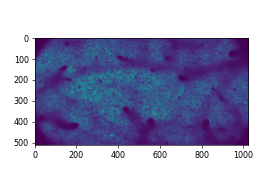

<IPython.core.display.Javascript object>


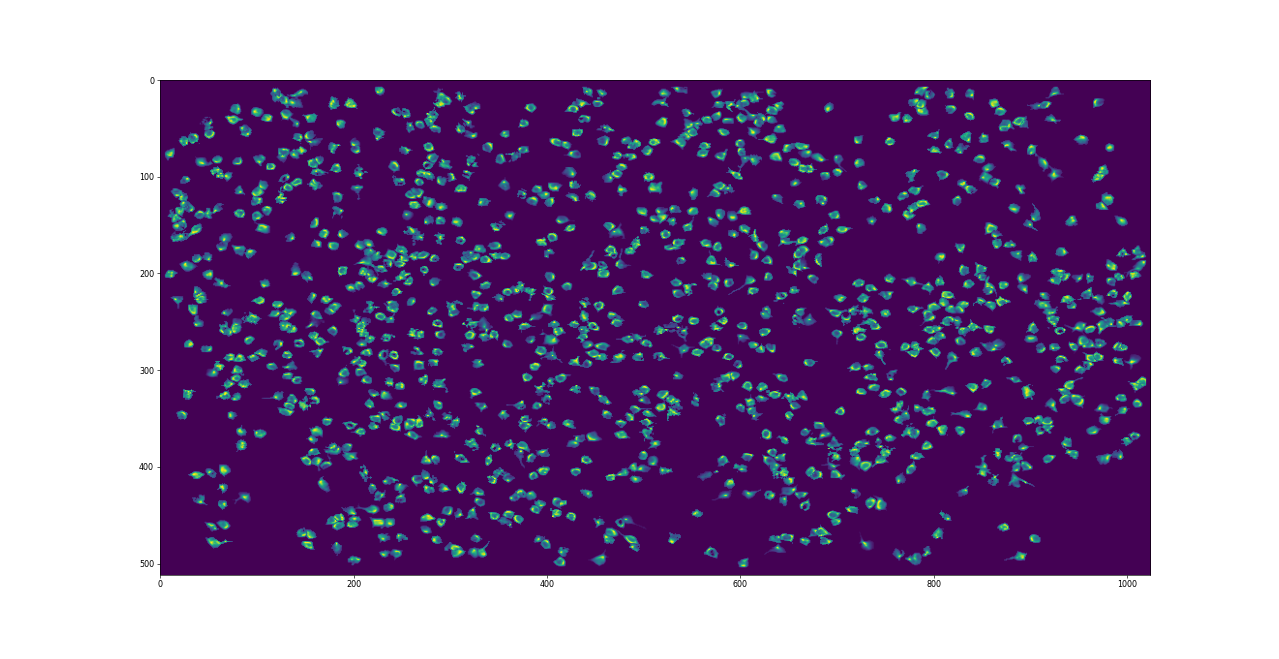

<IPython.core.display.Javascript object>


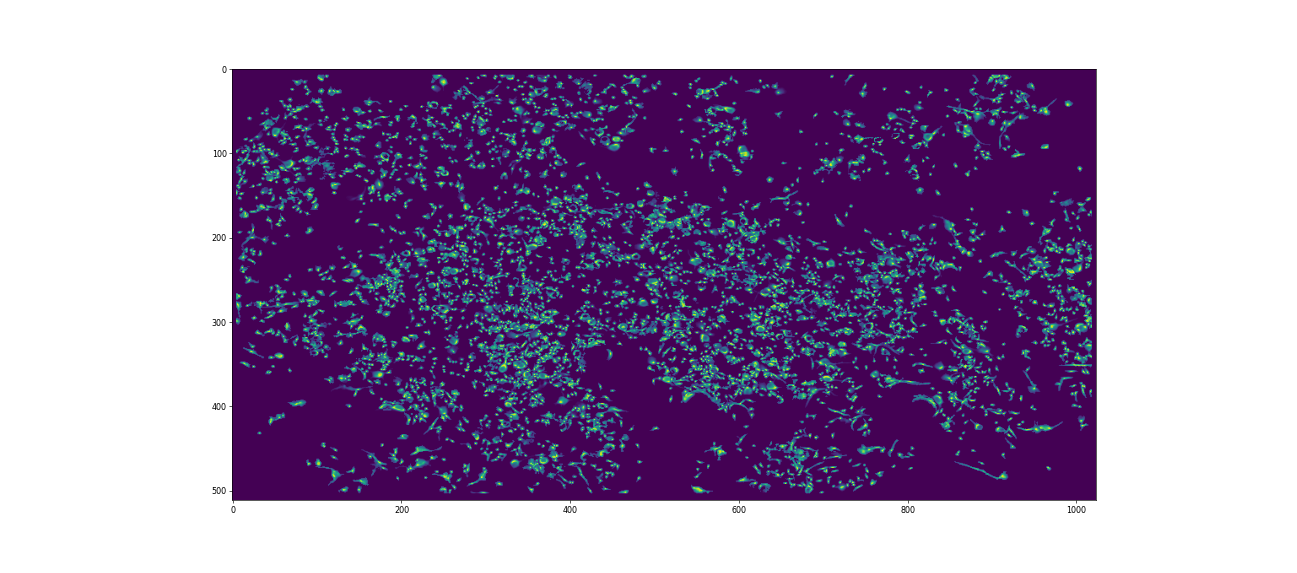

<IPython.core.display.Javascript object>


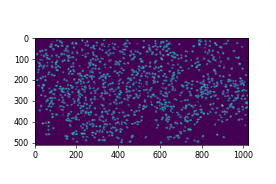

In [690]:
%matplotlib notebook

meanImg = ops[()]['meanImg']
frame_height = meanImg.shape[0]
frame_width = meanImg.shape[1]

plt.figure()
plt.imshow(meanImg)

masks_all_flat = np.zeros_like(meanImg)
simple_masks_all_flat = np.zeros_like(meanImg)
masks_all_unselected_flat = np.zeros_like(meanImg)
for ii in range(len(stat[()])):
    if is_cell_new[ii]==1:
#     if iscell[ii,0]:
        masks_all_flat[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
    else:
        masks_all_unselected_flat[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
    if iscell[ii,0]==1:
        simple_masks_all_flat[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])

plt.figure()
plt.imshow(masks_all_flat**1)
plt.figure()
plt.imshow(masks_all_unselected_flat**1)
plt.figure()
plt.imshow(simple_masks_all_flat)

In [402]:
## == Dim reduction ==

<IPython.core.display.Javascript object>


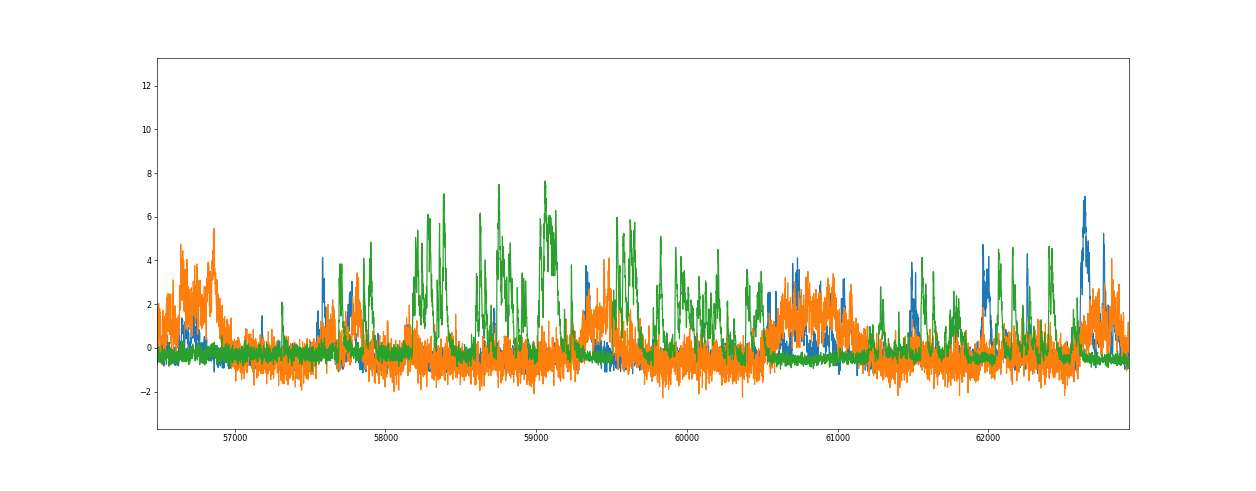

In [693]:
plt.figure()
plt.plot(F_zscore_roll[:,np.where(is_cell_new)[0][10:13]])
plt.figure()
plt.plot(F_zscore_roll[:,np.where(is_cell_new)[0][10:13]])

<IPython.core.display.Javascript object>


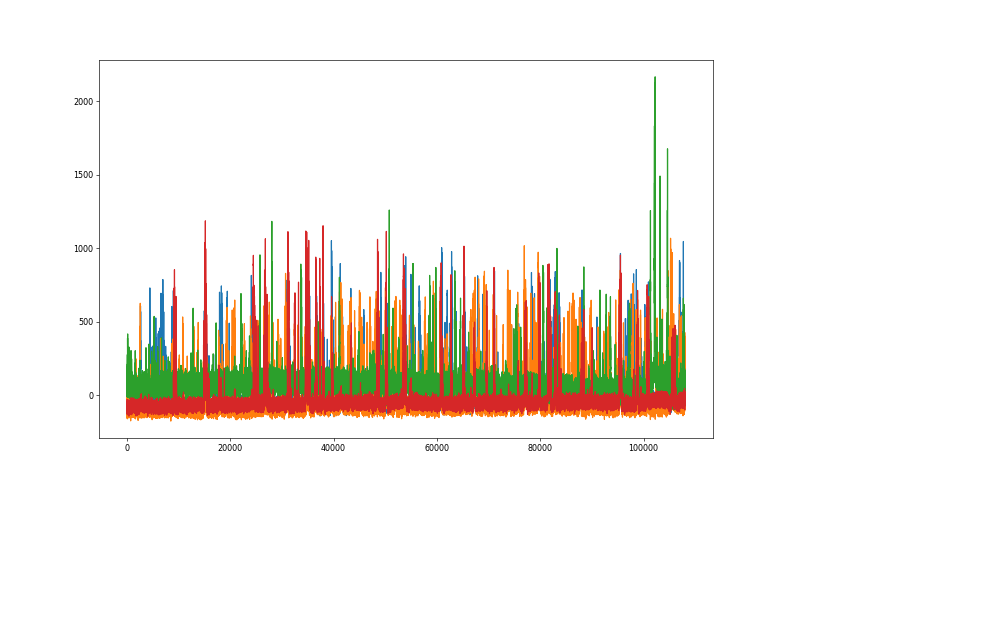

In [723]:
plt.figure()
plt.plot(dF[is_cell_new,:].T[:,:4])

<IPython.core.display.Javascript object>


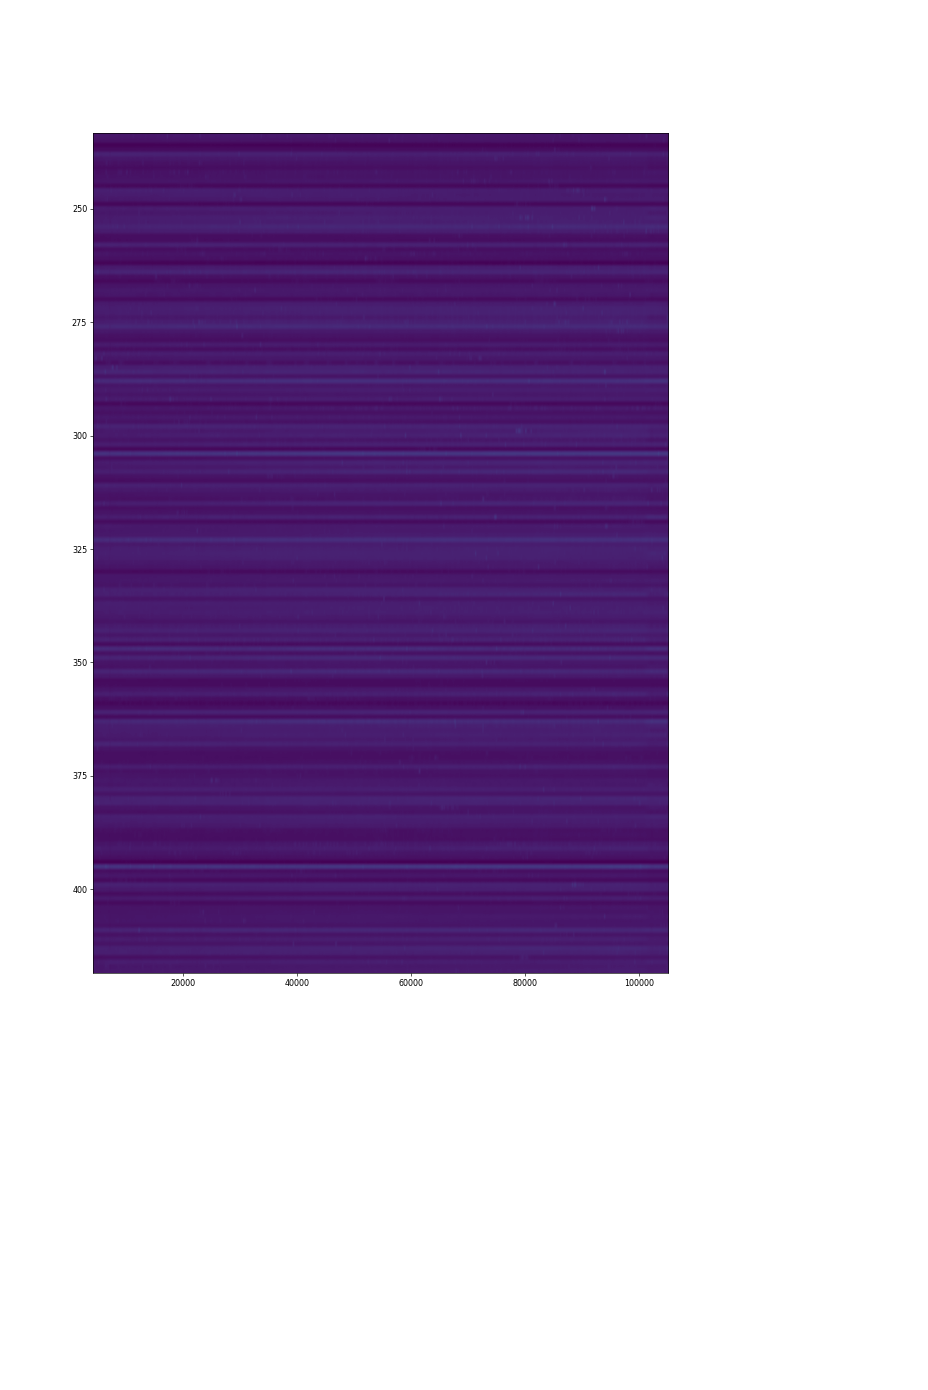

In [721]:
plt.figure()
plt.imshow(dFoF[is_cell_new,:] , aspect='auto',)

In [445]:
import sklearn.decomposition
import sklearn.model_selection

tic = time.time()

input_dimRed = F_zscore_roll[:,iscell[:,0]==True]
input_dimRed = F_zscore_roll[:,:800]
num_components = np.arange(1,11)

FA_components = list(np.arange(len(num_components)))
FA_scores = np.arange(len(num_components))
for ii, n_comp in enumerate(num_components):
    transformer = sklearn.decomposition.FactorAnalysis(n_components=n_comp, random_state=0 , rotation='varimax')
    transformer.fit_transform(np.single(input_dimRed).transpose())

    FA_components[ii] = transformer.components_
    FA_scores[ii] = np.mean(sklearn.model_selection.cross_val_score(transformer, input_dimRed , cv=5))

print(f'total elapsed time: {round((time.time() - tic)/60 , 2)} min')

total elapsed time: 4.31 min


<IPython.core.display.Javascript object>


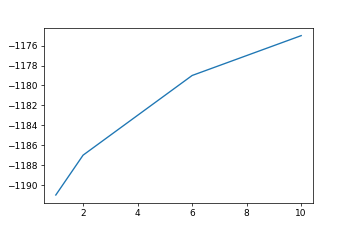

In [446]:
plt.figure()
plt.plot(num_components , FA_scores)

<IPython.core.display.Javascript object>


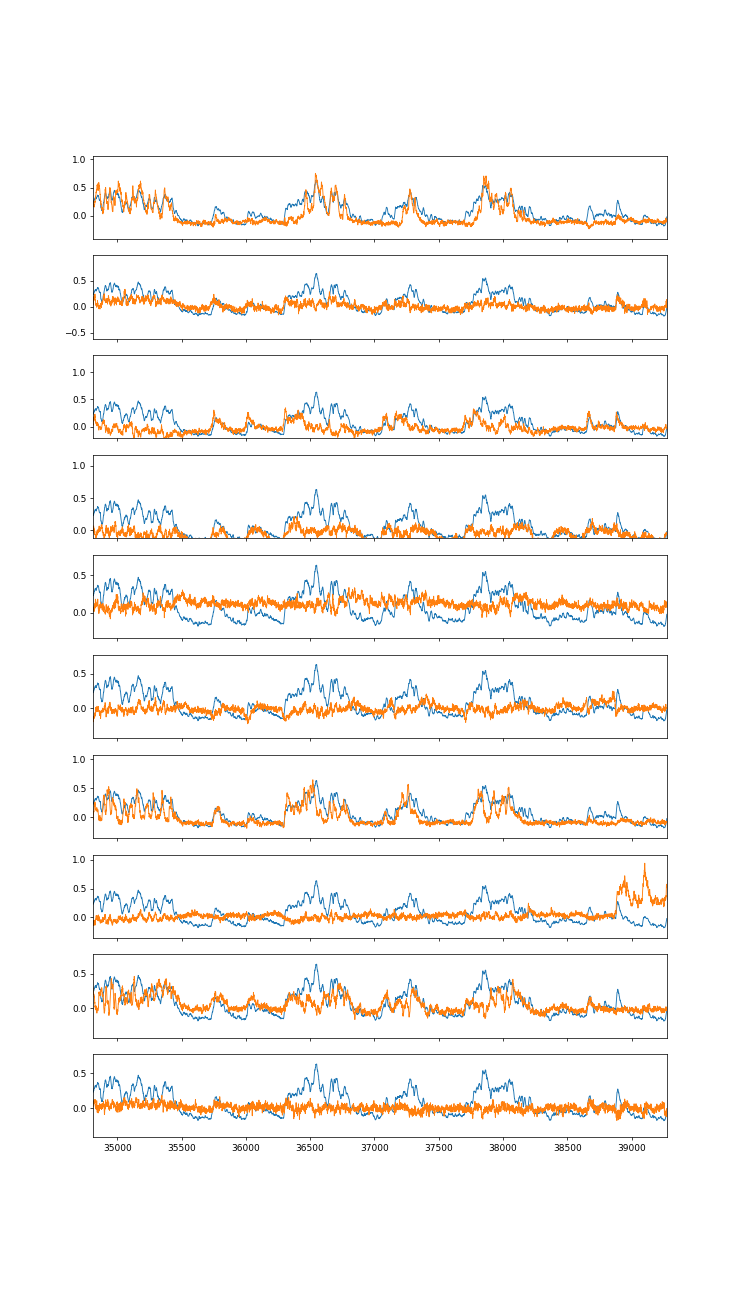

<IPython.core.display.Javascript object>


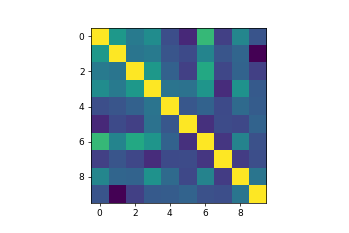

In [465]:
decomp_num_to_observe = 10
decomp_idx_to_use = np.where(num_components==decomp_num_to_observe)[0][0]


# plt.figure()
n_comp = FA_components[decomp_idx_to_use].shape[0]
# plt.subplot(n_comp,1,1, sharex=True, sharey=True)
fig, axs = plt.subplots(n_comp, 1, sharex=True, sharey=False)
for ii in range(n_comp):
#     axs[ii].plot(ws_treadmill_S2pInd/3 , linewidth=0.7)
#     axs[ii].plot(ws_licks_bool_S2pInd/10 , linewidth=0.7)
#     axs[ii].plot(ws_rewards_bool_S2pInd/5 , linewidth=0.7)
    axs[ii].plot(decoder_output_S2pWarped*3 , linewidth=1)
    axs[ii].plot(FA_components[decomp_idx_to_use][ii,:] , linewidth=1.0)

    
plt.figure()
plt.imshow(np.corrcoef(FA_components[decomp_idx_to_use]))

<IPython.core.display.Javascript object>


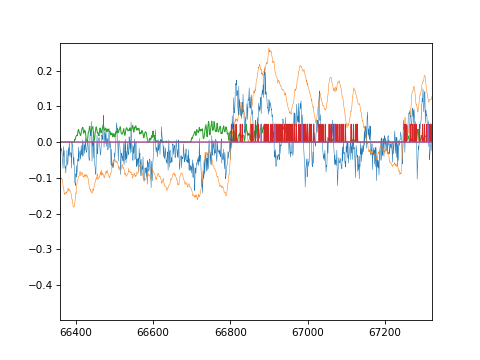

In [179]:
plt.figure()
# plt.plot(scipy.signal.savgol_filter(FA_components[decomp_idx_to_use][0,:] , 11,2) , linewidth=0.5)
plt.plot(FA_components[decomp_idx_to_use][2,:] , linewidth=0.5)
plt.plot(decoder_output*1, linewidth=0.5)
plt.plot(ws_treadmill_S2pInd / 20 , linewidth=1.0)
plt.plot(ws_licks_bool_S2pInd / 20 , linewidth=1.0)
plt.plot(ws_rewards_bool_S2pInd / 20 , linewidth=1.0)

In [24]:
## == REGRESSION ANALYSIS

(108000, 1073)


<IPython.core.display.Javascript object>


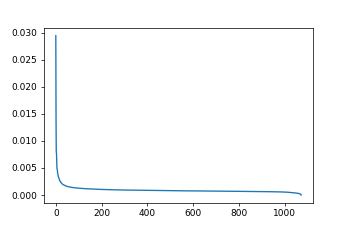

In [466]:
input_dimRed = F_zscore_roll[:,iscell[:,0]==True]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

print(output_PCA.shape)
plt.figure()
plt.plot(pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>


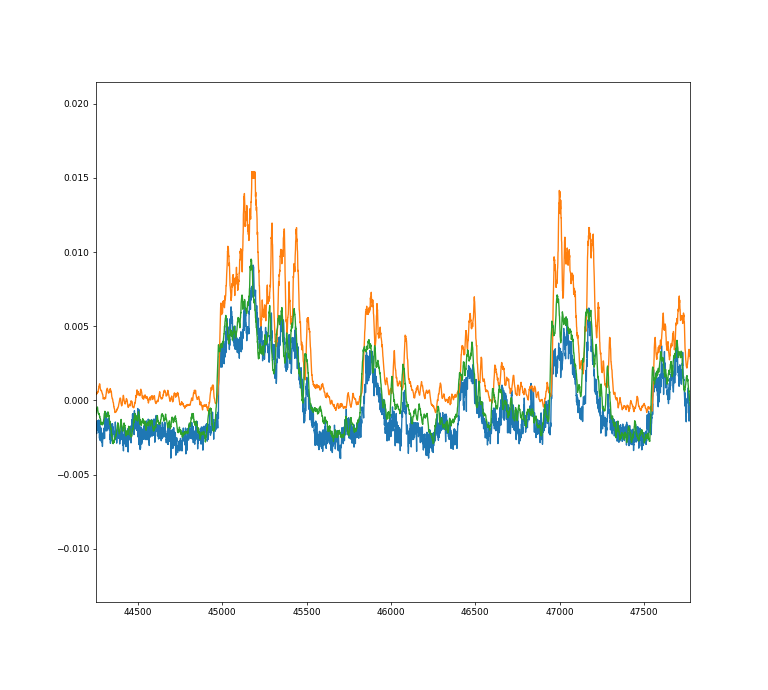

In [467]:
plt.figure()
plt.plot(output_PCA[:,:1])
plt.plot(ws_cursorVoltage_S2pInd/100)
plt.plot(decoder_output/20)

In [23]:
### REGRESSION

<IPython.core.display.Javascript object>


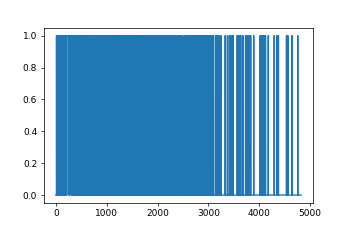

1009


In [498]:
plt.figure()
plt.plot(is_cell_new)
print(np.sum(is_cell_new))

In [748]:
tic = time.time()
# import sklearn.linear_model
# from catboost import CatBoostRegressor

L1_alpha = 10**-2.8


# idx_nonRunning = np.where(ws_treadmill_S2pInd[75000:] < 0.005)[0]
# idx_nonRunning = np.where(ws_treadmill_S2pInd[np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))] < 0.005)[0]
# idx_nonRunning = ws_treadmill_S2pInd < 0.005
idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
idx_nonRunning[:10000] = 0
idx_nonRunning[95000:] = 0
# idx_nonRunning = np.where(idx_nonRunning[tmp])[0]
# idx_nonRunning = np.where(idx_nonRunning[~np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))])[0]

# X_input = dFoF[IsCell_ROIClassifier==True,:].T
# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = F_zscore_roll[:,iscell[:,0]==True]
X_input = copy.deepcopy(F_zscore_roll[:,is_cell_new==True])
# X_input = copy.deepcopy(dFoF[is_cell_new,:].T)
# X_input = X_input - np.mean(X_input,axis=0)
X_input = X_input[:decoder_output_S2pWarped.shape[0] , :]
# X_input = copy.deepcopy(F_zscore_roll[:,is_cell_new==True])
# X_input = X_input[idx_nonRunning,:]

badROIs = np.where((np.sum(X_input==0,axis=0) == X_input.shape[0]) +
                  (np.sum(np.isnan(X_input),axis=0) == X_input.shape[0]))[0]
if len(badROIs) > 0:
    X_input[:,badROIs] = np.random.rand(X_input.shape[0],len(badROIs))
print(f'badROIs: {badROIs}')
    

y_input = copy.deepcopy(decoder_output_S2pWarped)
y_input[np.isnan(y_input)] = np.nanmean(y_input)
y_input = np.hstack((y_input[5:] , np.zeros(5)))
# y_input = y_input[idx_nonRunning]
# y_input[y_input<0] = 0
# y_input = y_input**(1/3)
# y_input = ws_licks_bool_S2pInd

# X = np.hstack((np.ones(spks.shape[1]).reshape(spks.shape[1],1) ,
#                np.linspace(0,1,spks.shape[1])[:,None],
#                X_input))
# X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) ,
               X_input,
#                np.random.rand(X_input.shape[0],20)
              ))

# # y_reconstructed_FF = np.zeros((X.shape[0] , num_factors))
# y_reconstructed = np.zeros((F_zscore_roll.shape[0] , 1))
# y = np.zeros((X.shape[0] , 1))
# R = np.zeros((1))
# theta = np.ones((X_input.shape[1]+1,1))


#     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor] ** (1/2)
#     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor]
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3)) ** (1/2)
y = y_input
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3))
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input , 101 , 3)) ** (1/2)
#     y[:,iter_factor] = abs(y_input) ** (1/2)

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

### SKLEARN regression
# clf = sklearn.linear_model.LinearRegression()
clf = sklearn.linear_model.Lasso(alpha=L1_alpha)
# clf = sklearn.linear_model.ElasticNet(alpha=1 , l1_ratio=0)
clf.fit(X_train , y_train )
theta = clf.coef_

#     ### CATBOOST regression
#     model = CatBoostRegressor(iterations=2000,
# #                               learning_rate=1,
# #                               depth=2,
#                               task_type="GPU",
#                               devices='0:1')
#     model.fit(X_train, y_train)
#     y_train_output = model.predict(X_train)
#     y_test_output = model.predict(X_test)

# theta = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'train R: {R_train}')

y_test_output = X_test @ theta
R_test = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'test  R: {R_test} , test  R^2: {R_test**2}')

#     y_reconstructed[:,iter_factor] = X @ theta_FF[:,iter_factor]
#     y_reconstructed_FF[:,iter_factor] = np.hstack((np.ones(F_zscore_roll.shape[0]).reshape(F_zscore_roll.shape[0],1) , F_zscore_roll[:,IsCell_ROIClassifier==True])) @ theta_FF[:,iter_factor]
y_reconstructed = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input)) @ theta

print(f'elapsed time: {round((time.time() - tic)/60 , 2)} min')

badROIs: []
train R: 0.9502900021868201
test  R: 0.9512391377227939 , test  R^2: 0.9048558971356044
elapsed time: 0.14 min


<IPython.core.display.Javascript object>


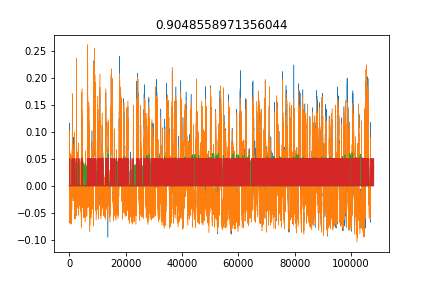

Text(0.5, 1.0, '0.9048558971356044')

In [749]:
y_reconstructed = X @ theta
# weights_RegressionAnalysisOutput
plt.figure()

plt.plot(y_input , linewidth=0.5)
plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(ws_treadmill_S2pInd / 20 , linewidth=1.0)
plt.plot(ws_licks_bool_S2pInd / 20 , linewidth=1.0)
plt.title(R_test**2)

<IPython.core.display.Javascript object>


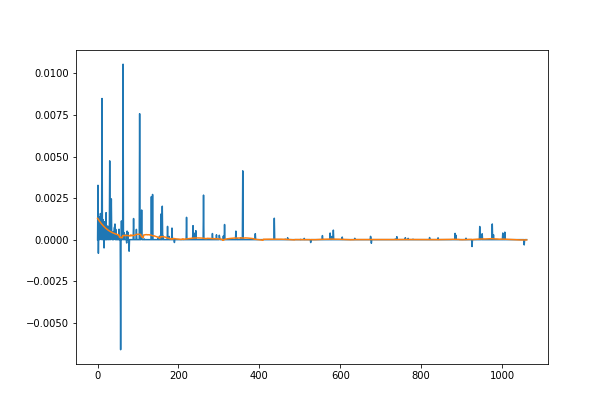

Number of non-zero coefficients: 105
Number of zero coefficients: 957


In [750]:
plt.figure()
plt.plot(theta[1:])
plt.plot(scipy.signal.savgol_filter(theta[1:] , 101 , 3))
print(f'Number of non-zero coefficients: {np.sum(theta[1:]!=0)}')
print(f'Number of zero coefficients: {np.sum(theta[1:]==0)}')

<IPython.core.display.Javascript object>


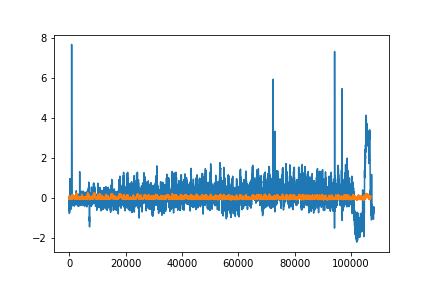

<IPython.core.display.Javascript object>


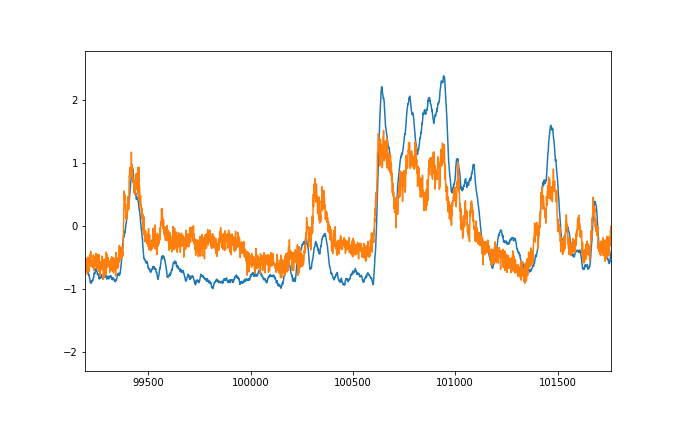

In [775]:
##plot the lowest and highest signal cells to be included
theta_tmp = copy.deepcopy(theta)
theta_tmp[theta_tmp==0] = 1*np.nan
plt.figure()
plt.plot(scipy.signal.savgol_filter(F_zscore_roll[:,
    np.where(is_cell_new)[0][np.where(theta[1:]==np.nanmin(np.abs(theta_tmp[1:])))[0][0]]] ,51,3))
plt.plot(y_reconstructed)

plt.figure()
plt.plot(scipy.signal.savgol_filter(F_zscore_roll[:,
    np.where(is_cell_new)[0][np.where(theta[1:]==np.nanmax(np.abs(theta_tmp[1:])))[0][0]]] ,51,3))
plt.plot(y_reconstructed*10)

treadmill, train R: 0.8087971111975796
treadmill, test  R: 0.7992766491709054
R^2: 0.6388431619098706


<IPython.core.display.Javascript object>


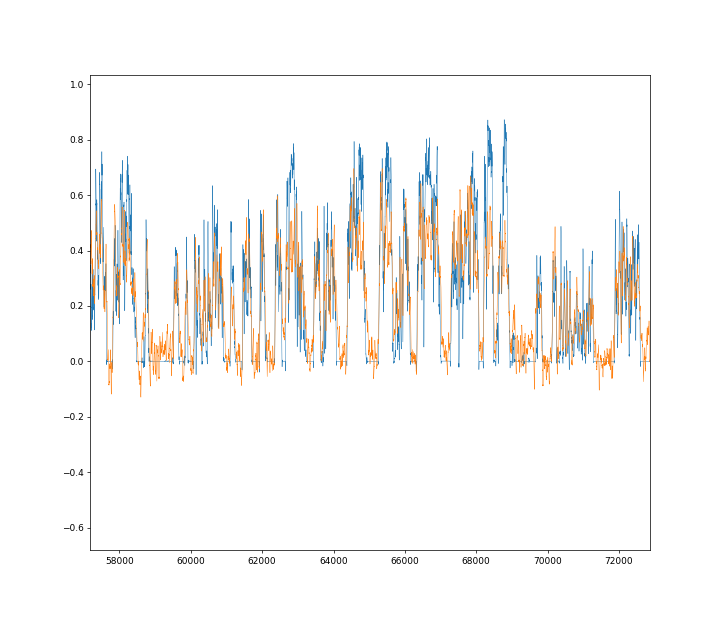

In [506]:
## Correlate to treadmill signal

idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
idx_nonRunning[:20000] = 0
idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,is_cell_new==True]
X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd[idx_nonRunning] , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)

treadmill, train R: 0.8492885359107544
treadmill, test  R: 0.8433935537800494


<IPython.core.display.Javascript object>


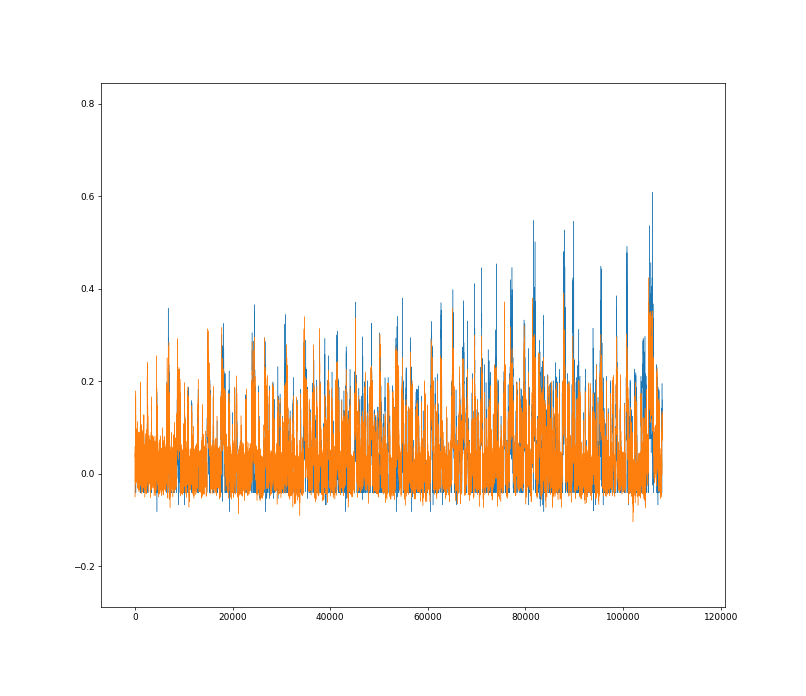

In [509]:
## Correlate to licking signal
idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
idx_nonRunning[:20000] = 0
idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,is_cell_new==True]
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
plt.plot(y_reconstructed , linewidth=0.5)
# plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)

In [770]:
## Saving output ensembles
import scipy.io

weights_RegressionAnalysisOutput = theta[1:]

regression_output = {"regression_goalSignal": y_input,
                     "regression_reconstruction": y_reconstructed,
                     "refit_identity": 'decoder_output'
                    }

weights_dayN = {
    "weights": weights_RegressionAnalysisOutput,
    "iscell_custom": is_cell_new,
    "win_size_rollingBaseline": win_size_rollingBaseline,
    "regression_output":regression_output,
    "R_test": R_test,
    "L1_alpha": L1_alpha,
}

dir_save = r'\\research.files.med.harvard.edu\Neurobio\MICROSCOPE\Rich\data\res2p\scanimage data\round 4 experiments\mouse 11.5\20210121'
save_name = 'weights_dayN'
save_fullPath = f'{dir_save}{slash_type}weights_dayN'

F = scipy.io.savemat(f'{save_fullPath}.mat' , weights_dayN)

np.save(f'{save_fullPath}.npy' , weights_dayN)

<IPython.core.display.Javascript object>


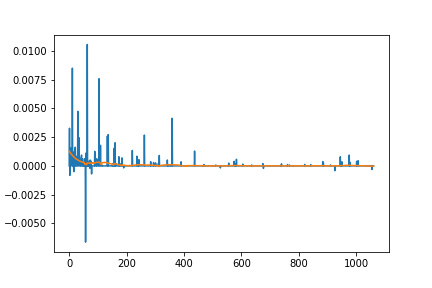

In [771]:
plt.figure()
plt.plot(weights_RegressionAnalysisOutput)
plt.plot(scipy.signal.savgol_filter(weights_RegressionAnalysisOutput , 101 , 3))

<IPython.core.display.Javascript object>


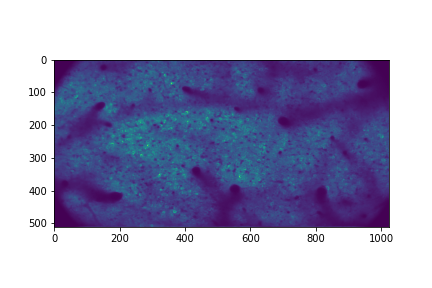

<IPython.core.display.Javascript object>


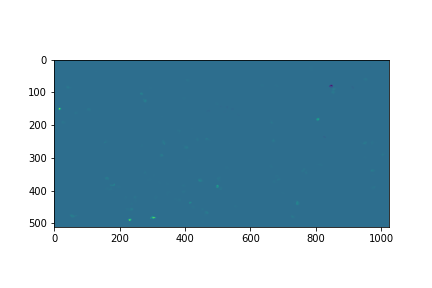

In [772]:
%matplotlib notebook

meanImg = ops[()]['meanImg']
frame_height = meanImg.shape[0]
frame_width = meanImg.shape[1]

plt.figure()
plt.imshow(meanImg)

cc=0
masks_all_flat_weighted = np.zeros_like(meanImg)
# masks_all_flat_weighted2 = np.zeros_like(meanImg)
for ii in range(len(stat[()])):
    if weights_dayN['iscell_custom'][ii]==1:
#         print(ii)
        masks_all_flat_weighted[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] * weights_dayN['weights'][cc]
#         masks_all_flat_weighted2[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] * theta[cc+1]

        cc+=1

plt.figure()
plt.imshow(masks_all_flat_weighted)
# plt.figure()
# plt.imshow(masks_all_flat_weighted2)
